In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from warnings import filterwarnings
filterwarnings('ignore')
from scipy.stats import chi2_contingency
import pandas as pd
from scipy.stats import f_oneway
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.datasets import load_iris
from sklearn.feature_selection import SelectFromModel
from statsmodels.stats.outliers_influence import variance_inflation_factor

In [2]:
df_set = pd.read_csv(r'C:\Users\xchri\OneDrive\Documents\bilgrit\Bird challenge\Bird Species Classification Dataset\Dataset\training_set\training_set.csv')
df_set.head()

,bill_depth,bill_length,wing_length,location,mass,sex,ID
0,14.300000,48.200000,210.000000,loc_2,4600.0,0.0,284
1,14.400000,48.400000,203.000000,loc_2,4625.0,0.0,101
2,18.400000,NaN,200.000000,loc_3,3400.0,0.0,400
3,14.982114,47.504878,NaN,NaN,4800.0,0.0,98
4,18.982114,38.259307,217.186992,loc_3,5200.0,0.0,103


In [3]:
df_tar = pd.read_csv(r'C:\Users\xchri\OneDrive\Documents\bilgrit\Bird challenge\Bird Species Classification Dataset\Dataset\training_set\training_target.csv')
df_tar.head()

,ID,species
0,284,C
1,101,C
2,400,B
3,98,C
4,103,C


In [4]:
# joining on ID column

In [5]:
def get_train_data():
    df = pd.merge(df_set, df_tar, how='inner', on = 'ID')
    return df


In [6]:
def independent_encod(df,col):
    from sklearn.preprocessing import LabelEncoder, OneHotEncoder
    encoder = LabelEncoder()
    df[col] = encoder.fit_transform(df[col].astype('str'))
    cat_nan = encoder.transform(['nan'])[0]
    df[col].replace(cat_nan,np.NAN,inplace = True)

In [7]:
def encod_dependent(df,col):
    from sklearn.preprocessing import LabelEncoder, OneHotEncoder
    encoder = LabelEncoder()
    df[col] = encoder.fit_transform(df[col].astype('str'))

In [8]:
def scaler(df):
    from sklearn.preprocessing import MinMaxScaler
    scaler = MinMaxScaler()
    col_list = df.select_dtypes(exclude = 'object').columns
    df[col_list] = scaler.fit_transform(df[col_list])
    return df

In [9]:
def median_imputer(df):
    from sklearn.impute import SimpleImputer
    si = SimpleImputer(strategy='median')
    df_num = df.select_dtypes(exclude='object')
    col_list = df_num.loc[:,df_num.isnull().any()].columns
    df[col_list] = si.fit_transform(df[col_list])
    return df

In [10]:
def mode_imputer(df):
    from sklearn.impute import SimpleImputer
    si = SimpleImputer(strategy='most_frequent')
    df_num = df.select_dtypes(include='object')
    col_list = df_num.loc[:,df_num.isnull().any()].columns
    df[col_list] = si.fit_transform(df[col_list])
    return df

In [11]:
# filling missing value 
def impute(df,col_list):
    from sklearn.impute import KNNImputer, impute
    knn = impute()
    df[col_list] = knn.fit_transform(df[col_list])
    return df

In [12]:
def get_models():
    models = []
    models.append(LogisticRegression())
    models.append(DecisionTreeClassifier())
    models.append(RandomForestClassifier())
    models.append(GaussianNB())
    models.append(SGDClassifier())
    models.append(KNeighborsClassifier())
    models.append(SVC())
    return models

In [13]:
def train_test_split(df):
    x = df.drop('species',axis = 1)
    y = df['species']
    from sklearn.model_selection import train_test_split
    xtrain,xtest,ytrain,ytest = train_test_split(x,y,test_size=0.3,random_state=0)
    return xtrain,xtest,ytrain,ytest

In [14]:
def central_tendency(df):
    mean = []
    median = []
    mode = []
    skew = []
    df_dummy = pd.DataFrame(index = df.columns)
    for col in df.columns:
        mean.append(round(df[col].mean(),2))
        median.append(round(df[col].median(),2))
        mode.append(round(df[col].mode()[0],2))
        skew.append(round(df[col].skew(),2))

    df_dummy['mean'] = mean
    df_dummy['median'] = median
    df_dummy['mode'] = mode
    df_dummy['skew'] = skew
    return df_dummy

In [15]:
def redundant_removal(df):
    df = df.drop(df.corr()[(df.corr()['species']<0.5)&(df.corr()['species']>-0.5)].index,axis = 1)
    return df

# loading data

In [16]:
df = get_train_data()
df.head()

,bill_depth,bill_length,wing_length,location,mass,sex,ID,species
0,14.300000,48.200000,210.000000,loc_2,4600.0,0.0,284,C
1,14.400000,48.400000,203.000000,loc_2,4625.0,0.0,101,C
2,18.400000,NaN,200.000000,loc_3,3400.0,0.0,400,B
3,14.982114,47.504878,NaN,NaN,4800.0,0.0,98,C
4,18.982114,38.259307,217.186992,loc_3,5200.0,0.0,103,C


In [17]:
df['species'].value_counts()

C    182
A    160
B     93
Name: species, dtype: int64

# encoding

In [18]:
independent_encod(df,'location')
independent_encod(df,'sex')
encod_dependent(df,'species')
df.head()

,bill_depth,bill_length,wing_length,location,mass,sex,ID,species
0,14.300000,48.200000,210.000000,1.0,4600.0,0.0,284,2
1,14.400000,48.400000,203.000000,1.0,4625.0,0.0,101,2
2,18.400000,NaN,200.000000,2.0,3400.0,0.0,400,1
3,14.982114,47.504878,NaN,NaN,4800.0,0.0,98,2
4,18.982114,38.259307,217.186992,2.0,5200.0,0.0,103,2


In [19]:
df['species'].value_counts()

2    182
0    160
1     93
Name: species, dtype: int64

In [20]:
df.dtypes

bill_depth     float64
bill_length    float64
wing_length    float64
location       float64
mass           float64
sex            float64
ID               int64
species          int32
dtype: object

In [21]:
# location and sex are categorical columns
df['location'] = df['location'].astype('object')
df['sex'] = df['sex'].astype('object')

In [22]:
df.dtypes

bill_depth     float64
bill_length    float64
wing_length    float64
location        object
mass           float64
sex             object
ID               int64
species          int32
dtype: object

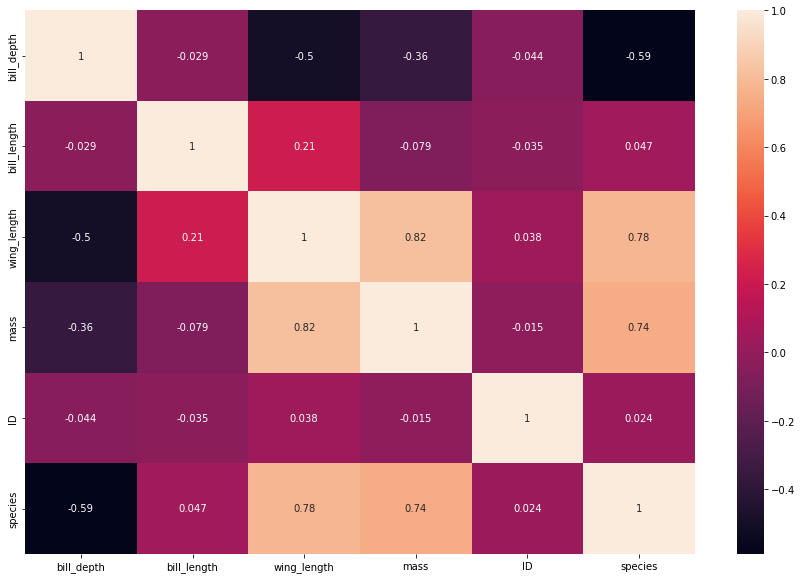

In [23]:
# correlation matrix
plt.figure(figsize = (15,10))
sns.heatmap(df.corr(),annot = True)
plt.show()

# redundant columns removal

In [24]:
df.drop('ID',axis = 1,inplace = True)

In [25]:
df.head()

,bill_depth,bill_length,wing_length,location,mass,sex,species
0,14.300000,48.200000,210.000000,1.0,4600.0,0.0,2
1,14.400000,48.400000,203.000000,1.0,4625.0,0.0,2
2,18.400000,NaN,200.000000,2.0,3400.0,0.0,1
3,14.982114,47.504878,NaN,NaN,4800.0,0.0,2
4,18.982114,38.259307,217.186992,2.0,5200.0,0.0,2


# treating missing values

In [26]:
df.head()

,bill_depth,bill_length,wing_length,location,mass,sex,species
0,14.300000,48.200000,210.000000,1.0,4600.0,0.0,2
1,14.400000,48.400000,203.000000,1.0,4625.0,0.0,2
2,18.400000,NaN,200.000000,2.0,3400.0,0.0,1
3,14.982114,47.504878,NaN,NaN,4800.0,0.0,2
4,18.982114,38.259307,217.186992,2.0,5200.0,0.0,2


In [27]:
#df.loc[:,df.isnull().any()].columns

In [28]:
df_filled = median_imputer(df)

df_filled = mode_imputer(df_filled)

df_filled.head()

,bill_depth,bill_length,wing_length,location,mass,sex,species
0,14.300000,48.200000,210.000000,1.0,4600.0,0.0,2
1,14.400000,48.400000,203.000000,1.0,4625.0,0.0,2
2,18.400000,47.500000,200.000000,2.0,3400.0,0.0,1
3,14.982114,47.504878,199.000000,1.0,4800.0,0.0,2
4,18.982114,38.259307,217.186992,2.0,5200.0,0.0,2


In [29]:
df_filled.isnull().sum()

bill_depth     0
bill_length    0
wing_length    0
location       0
mass           0
sex            0
species        0
dtype: int64

# correlation check

### continuous and categorical column

In [30]:
# hypothesis
# h0 --> both columns are not related to each other
# h1 --> both columns are related to each other

### bill_length vs species

In [41]:



# Separate the continuous and categorical variables
continuous_var = df_filled['bill_length']
categorical_var = df_filled['species']

# Use one-way ANOVA to calculate the correlation
f_stat, p_val = f_oneway(continuous_var[categorical_var==0],
                         continuous_var[categorical_var==1],
                         continuous_var[categorical_var==2])

# Print the F-statistic and its significance level
print('F-statistic:', f_stat)
print('p-value:', p_val)

F-statistic: 46.7550178935733
p-value: 4.159012547095216e-19


In [32]:
# we fail to accept the null hypothesis. bill_length is correlated to target column

### bill_depth vs species

In [42]:


# Separate the continuous and categorical variables
continuous_var = df_filled['bill_depth']
categorical_var = df_filled['species']

# Use one-way ANOVA to calculate the correlation
f_stat, p_val = f_oneway(continuous_var[categorical_var==0],
                         continuous_var[categorical_var==1],
                         continuous_var[categorical_var==2])

# Print the F-statistic and its significance level
print('F-statistic:', f_stat)
print('p-value:', p_val)

F-statistic: 161.95333628880493
p-value: 3.2761415016384325e-53


In [34]:
# we fail to accept the null hypothesis. bill_depth is correlated to target column

### wing_length vs species

In [43]:
# Separate the continuous and categorical variables
continuous_var = df_filled['wing_length']
categorical_var = df_filled['species']

# Use one-way ANOVA to calculate the correlation
f_stat, p_val = f_oneway(continuous_var[categorical_var==0],
                         continuous_var[categorical_var==1],
                         continuous_var[categorical_var==2])

# Print the F-statistic and its significance level
print('F-statistic:', f_stat)
print('p-value:', p_val)

F-statistic: 164.053278554196
p-value: 9.899239785449621e-54


In [36]:
# we fail to accept the null hypothesis. wing_length is correlated to target column

### mass vs species

In [44]:
# Separate the continuous and categorical variables
continuous_var = df_filled['mass']
categorical_var = df_filled['species']

# Use one-way ANOVA to calculate the correlation
f_stat, p_val = f_oneway(continuous_var[categorical_var==0],
                         continuous_var[categorical_var==1],
                         continuous_var[categorical_var==2])

# Print the F-statistic and its significance level
print('F-statistic:', f_stat)
print('p-value:', p_val)

F-statistic: 427.7327020367708
p-value: 3.644237465248228e-103


In [38]:
# we fail to accept the null hypothesis. mass is correlated to target column

# Location vs species

In [46]:
# categorical columns
crosstab = pd.crosstab(index=df_filled['location'], columns=df_filled['species'])
crosstab

species,0,1,2
location,,,
0.0,55,11,17
1.0,42,24,145
2.0,63,58,20


In [47]:
chi2_results = chi2_contingency(crosstab)

In [48]:
pvalue = chi2_results[1]
pvalue

6.049881179660023e-31

In [49]:
# we fail to accept hypothesis. The both columns are related to each other.

# Sex vs species

In [112]:
df_filled['sex'] = df_filled['sex'].replace({0.0:0,1.0:1})
df_filled['sex'] = df_filled['sex'].astype('object')

In [113]:
# sex vs species
crosstab = pd.crosstab(index=df_filled['sex'], columns=df_filled['species'])
crosstab

species,0,1,2
sex,,,
0,68,42,74
1,92,51,108


In [51]:
# hypothesis
# h0 --> both columns are not related to each other
# h1 --> both columns are related to each other

In [114]:
chi2_results = chi2_contingency(crosstab)

In [115]:
pvalue = chi2_results[1]
pvalue

0.7728655423667019

In [54]:
# we accept null hypothesis. The both columns are not related to each other.

In [55]:
# hence sex column can be removed from the dataset.

In [56]:
df_final = df_filled.drop('sex',axis = 1)
df_final.head()

,bill_depth,bill_length,wing_length,location,mass,species
0,14.300000,48.200000,210.000000,1.0,4600.0,2
1,14.400000,48.400000,203.000000,1.0,4625.0,2
2,18.400000,47.500000,200.000000,2.0,3400.0,1
3,14.982114,47.504878,199.000000,1.0,4800.0,2
4,18.982114,38.259307,217.186992,2.0,5200.0,2


# train test split

In [129]:
xtrain,xtest,ytrain,ytest = train_test_split(df_final)

In [130]:
xtest.head()

,bill_depth,bill_length,wing_length,location,mass,bill_area
153,18.6,55.512336,190.0,2.0,3450.0,1032.529441
264,18.4,48.833824,200.0,1.0,3400.0,898.542353
54,17.9,47.500000,199.0,1.0,3200.0,850.250000
355,18.1,47.500000,199.0,2.0,4300.0,859.750000
428,14.0,47.500000,212.0,1.0,4875.0,665.000000


# stratifying the train and test datasets

In [59]:
# the target variable is imbalanced and it will not provide good accuracy on unknown data
# hence we will be using stratified k fold to get the better accuracy.
# k fold cv is used for evaluating the model performances

In [60]:
# K fold
from sklearn.model_selection import StratifiedKFold, cross_val_score
kfold = StratifiedKFold(n_splits=5,  shuffle=True, random_state=0)


In [61]:
X = df_final.drop('species', axis = 1)
y = df_final['species']

In [62]:
train_indices = []
test_indices = []
for train_ind, test_ind in kfold.split(X,y):
    train_indices.append(train_ind)
    test_indices.append(test_ind)
#     train_x, test_x = X[train_ind], X[test_ind]
#     train_y, test_y = y[train_ind], y[test_ind]


In [63]:
xtrain_strfd = X.iloc[train_indices[0]]
ytrain_strfd = y.iloc[train_indices[0]]

In [64]:
xtest_strfd = X.iloc[test_indices[0]]
ytest_strfd = y.iloc[test_indices[0]]

In [65]:
ytrain_strfd.value_counts()

2    145
0    128
1     75
Name: species, dtype: int64

In [66]:
ytest_strfd.value_counts()

2    37
0    32
1    18
Name: species, dtype: int64

# scaling

In [67]:
# xtrain scaling
xtrain_scaled = scaler(xtrain_strfd) # Minmax scaler
#xtest scaling
xtest_scaled = scaler(xtest_strfd)

In [68]:
xtrain_scaled.head()

,bill_depth,bill_length,wing_length,location,mass
0,0.142857,0.465809,0.655172,1.0,0.527778
2,0.630952,0.433008,0.482759,2.0,0.194444
4,0.700252,0.000000,0.779086,2.0,0.694444
5,0.226190,0.531412,0.758621,1.0,0.569444
6,0.607143,0.433008,0.431034,2.0,0.291667


In [69]:
xtest_scaled.head()

,bill_depth,bill_length,wing_length,location,mass
1,0.042254,0.587763,0.404255,1.0,0.541667
3,0.124241,0.535881,0.319149,1.0,0.600000
8,0.687622,0.000000,0.319149,0.0,0.800000
17,0.676056,0.535598,0.319149,0.0,0.383333
19,0.521127,0.471841,0.148936,2.0,0.233333


# feature selection

In [70]:


# Create an ExtraTreesClassifier object
clf = ExtraTreesClassifier(n_estimators=100)

# Fit the classifier to the data
clf = clf.fit(xtrain_scaled,ytrain_strfd)

# Print the feature importances
print(clf.feature_importances_)

# Use SelectFromModel to select features based on their importance
sfm = SelectFromModel(clf, threshold=0.1)
sfm.fit(xtrain_scaled,ytrain_strfd)

# Print the selected features
print('\nImportant features are :')
print(clf.feature_names_in_[sfm.get_support()])

[0.21410334 0.23803722 0.19842479 0.08040176 0.26903289]

Important features are :
['bill_depth' 'bill_length' 'wing_length' 'mass']


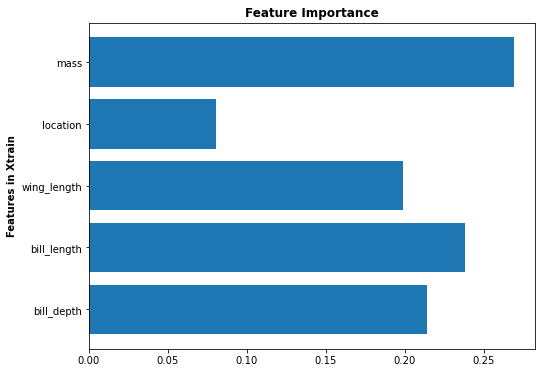

In [71]:
plt.figure(figsize = (8,6))
plt.barh(xtrain_scaled.columns,clf.feature_importances_)
plt.title('Feature Importance',fontweight = 'bold')
plt.ylabel('Features in Xtrain', fontweight = 'bold')
plt.show()

<Figure size 1080x720 with 0 Axes>

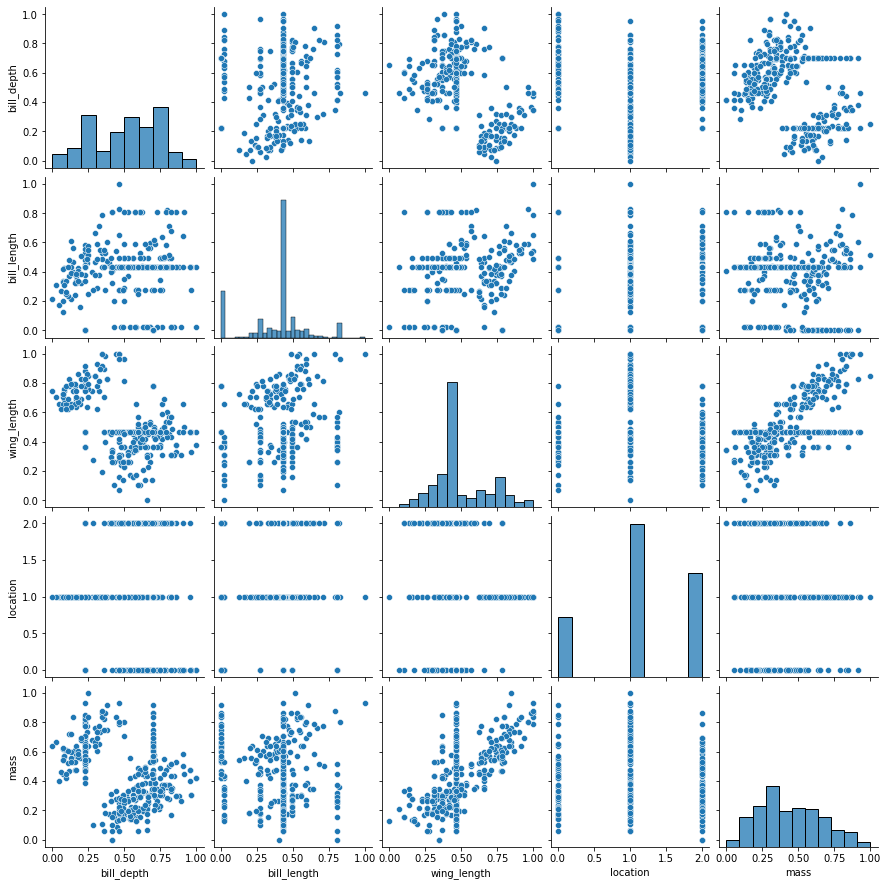

In [72]:
#pair plot
plt.figure(figsize = (15,10))
sns.pairplot(xtrain_scaled.iloc[:])
plt.show()

In [73]:
# wing_length and mass are correlated. will use feature importance technique to remove the less important feature.
# but these correlation are not affecting the decision tree and random forest models

# Transformation

In [74]:
xtrain_strfd.dtypes

bill_depth     float64
bill_length    float64
wing_length    float64
location        object
mass           float64
dtype: object

In [75]:
from scipy.stats import boxcox
def boxcox_transformation(df):
    col_list = df.select_dtypes(exclude = 'object').columns
    for i in col_list:
        df[i],_ = boxcox(df[i]+1)
    return df

In [76]:
xtrain_transformed = boxcox_transformation(xtrain_scaled)
xtest_transformed = boxcox_transformation(xtest_scaled)

<Figure size 1080x720 with 0 Axes>

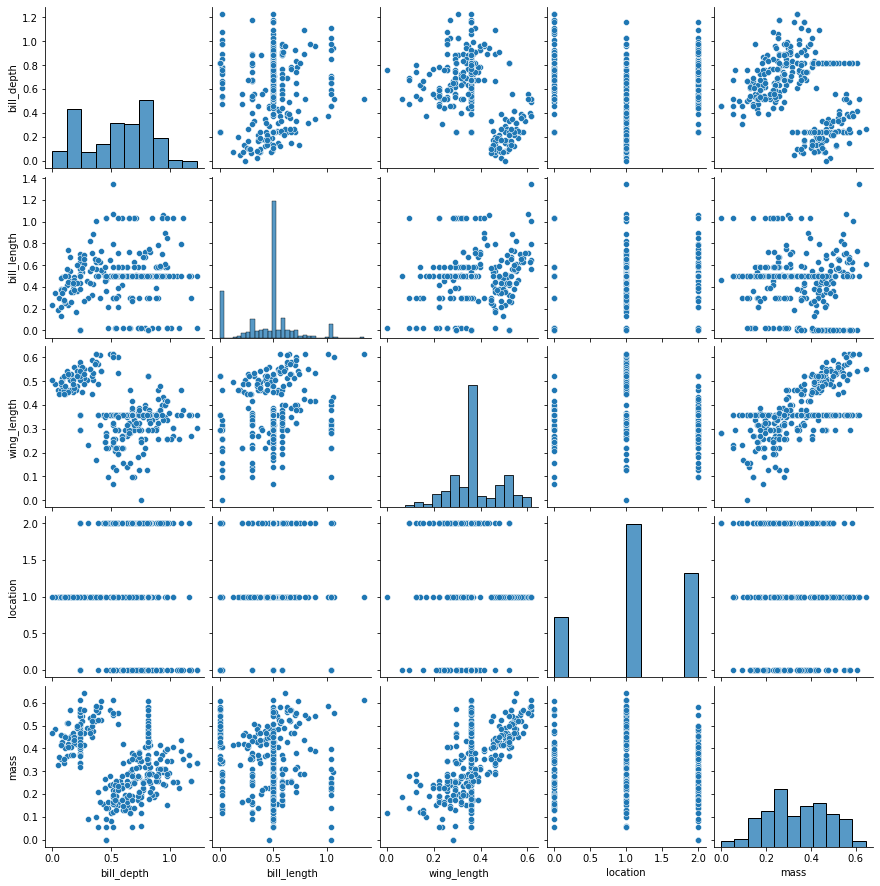

In [77]:
#pair plot
plt.figure(figsize = (15,10))
sns.pairplot(xtrain_transformed.iloc[:])
plt.show()

<AxesSubplot:>

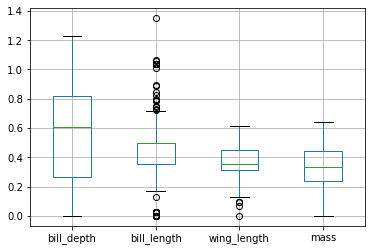

In [78]:
xtrain_transformed.boxplot()

In [79]:
# bill_length has huge outliers. we build the models with outliers.

# model building

In [80]:
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import HistGradientBoostingClassifier

In [81]:
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import SGDClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC


In [82]:
lr = LogisticRegression()
dc = DecisionTreeClassifier()
rfc = RandomForestClassifier()
nb = GaussianNB()
sgd = SGDClassifier()
knn = KNeighborsClassifier()
svc = SVC()

 algorithms which support missing values 
hgbc = HistGradientBoostingClassifier()
rfc = RandomForestClassifier()
knn = KNeighborsClassifier()

In [83]:
from sklearn.metrics import f1_score, accuracy_score,precision_score,recall_score,roc_auc_score,classification_report

In [84]:
xtrain_transformed.shape, ytrain_strfd.shape

((348, 5), (348,))

In [85]:
xtest_transformed.shape, ytest_strfd.shape

((87, 5), (87,))

In [86]:
train_scores = []
test_scores = []
for i in [lr,dc,rfc,nb,sgd,knn,svc]:
    i.fit(xtrain_transformed,ytrain_strfd)
    train_scores.append(i.score(xtrain_transformed,ytrain_strfd))
    test_scores.append(i.score(xtest_transformed,ytest_strfd))

In [87]:
df_scores = pd.DataFrame( index = ['Logistic Regression','Decision Tree',
                                   'Random Forest','Naive Bayes','Stochostic Gradient Descent','KNN','SVC'])
#df_scores.sort_values(by = ['Accuracy Scores','F1 Scores'], ascending = False) 
df_scores['Train_score'], df_scores['Test_score'] = train_scores,test_scores

In [88]:
df_scores.sort_values(by = ['Test_score'], ascending = False)

,Train_score,Test_score
Naive Bayes,0.847701,0.827586
SVC,0.847701,0.827586
Logistic Regression,0.816092,0.816092
KNN,0.882184,0.758621
Stochostic Gradient Descent,0.824713,0.678161
Random Forest,1.000000,0.655172
Decision Tree,1.000000,0.528736


# hyperparameter tuning for Guassian NB

In [89]:
from sklearn.model_selection import GridSearchCV
from sklearn.naive_bayes import GaussianNB
from sklearn.datasets import load_iris

# Create an instance of the GaussianNB class
gnb = GaussianNB()

# Define the hyperparameter grid to search
param_grid = {'var_smoothing': [1e-9, 1e-8, 1e-7, 1e-6, 1e-5]}

# Create an instance of the GridSearchCV class with 5-fold cross-validation
grid_search = GridSearchCV(gnb, param_grid, cv=5)

# Fit the GridSearchCV object to the iris dataset
grid_search.fit(xtrain_transformed,ytrain_strfd)

# Print the best hyperparameters
print("Best var_smoothing: ", grid_search.best_params_['var_smoothing'])
print("Best score: ", grid_search.best_score_)

Best var_smoothing:  1e-09
Best score:  0.8333747412008282


# test data import

In [90]:
# test data import 
df_test = pd.read_csv(r'C:\Users\xchri\OneDrive\Documents\bilgrit\Bird challenge\Bird Species Classification Dataset\Dataset\test_set\test_set.csv')
df_test.head()

,bill_depth,bill_length,wing_length,location,mass,sex,ID
0,14.982114,38.259307,217.186992,loc_2,5400.0,0.0,2
1,13.200000,46.100000,211.000000,loc_2,4500.0,0.0,5
2,20.000000,NaN,197.000000,loc_3,3300.0,1.0,7
3,17.500000,38.791391,190.000000,loc_3,3900.0,NaN,8
4,18.900000,NaN,184.000000,loc_2,3550.0,1.0,9


In [91]:
test_id = df_test['ID']

In [92]:
df_test = df_test.drop('ID', axis = 1)
df_test.head()

,bill_depth,bill_length,wing_length,location,mass,sex
0,14.982114,38.259307,217.186992,loc_2,5400.0,0.0
1,13.200000,46.100000,211.000000,loc_2,4500.0,0.0
2,20.000000,NaN,197.000000,loc_3,3300.0,1.0
3,17.500000,38.791391,190.000000,loc_3,3900.0,NaN
4,18.900000,NaN,184.000000,loc_2,3550.0,1.0


In [93]:
independent_encod(df_test,'location')

independent_encod(df_test,'sex')

df_test.head()

,bill_depth,bill_length,wing_length,location,mass,sex
0,14.982114,38.259307,217.186992,1.0,5400.0,0.0
1,13.200000,46.100000,211.000000,1.0,4500.0,0.0
2,20.000000,NaN,197.000000,2.0,3300.0,1.0
3,17.500000,38.791391,190.000000,2.0,3900.0,NaN
4,18.900000,NaN,184.000000,1.0,3550.0,1.0


In [94]:
df_test.dtypes

bill_depth     float64
bill_length    float64
wing_length    float64
location       float64
mass           float64
sex            float64
dtype: object

In [95]:
df_test.isnull().sum()

bill_depth      1
bill_length    41
wing_length    38
location        6
mass            1
sex            17
dtype: int64

In [96]:
df_test['location'] = df['location'].astype('object')
df_test['sex'] = df['sex'].astype('object')

In [97]:
df_test.dtypes

bill_depth     float64
bill_length    float64
wing_length    float64
location        object
mass           float64
sex             object
dtype: object

In [98]:
# filling missing values
#df_test = mode_imputer(df_test)
df_test = median_imputer(df_test)

#scaling

df_test = scaler(df_test)

df_test.head()


,bill_depth,bill_length,wing_length,location,mass,sex
0,0.222764,0.000000,0.753596,1.0,0.739130,0.0
1,0.000000,0.454453,0.634615,1.0,0.478261,0.0
2,0.850000,0.492128,0.365385,2.0,0.130435,0.0
3,0.537500,0.030840,0.230769,1.0,0.304348,0.0
4,0.712500,0.492128,0.115385,2.0,0.202899,0.0


In [99]:
df_test.isnull().sum()

bill_depth     0
bill_length    0
wing_length    0
location       0
mass           0
sex            0
dtype: int64

In [100]:
columns = xtrain_transformed.columns
df_test = df_test[columns]
df_test.head()

,bill_depth,bill_length,wing_length,location,mass
0,0.222764,0.000000,0.753596,1.0,0.739130
1,0.000000,0.454453,0.634615,1.0,0.478261
2,0.850000,0.492128,0.365385,2.0,0.130435
3,0.537500,0.030840,0.230769,1.0,0.304348
4,0.712500,0.492128,0.115385,2.0,0.202899


In [101]:
# prediction

In [102]:
predict = nb.predict(df_test)

predict.replace({1:'A',2:'B',3:'C'})

In [103]:
df_pred = pd.DataFrame(data = predict, columns = ['Prediction'])

In [104]:
df_pred=df_pred.replace({0:'A',1:'B',2:'C'})
df_pred = pd.concat([test_id,df_pred],axis = 1)
df_pred.head()

,ID,Prediction
0,2,C
1,5,C
2,7,A
3,8,A
4,9,A


In [105]:
df_pred['Prediction'].value_counts()

C    50
A    48
B    11
Name: Prediction, dtype: int64

In [106]:
df_pred.head()

,ID,Prediction
0,2,C
1,5,C
2,7,A
3,8,A
4,9,A


In [107]:
df_pred.describe()

,ID
count,109.000000
mean,267.440367
std,152.644433
min,2.000000
25%,139.000000
50%,269.000000
75%,392.000000
max,541.000000


In [108]:
df_pred.to_csv('prediction.csv', index = False)